<a href="https://colab.research.google.com/github/rafisagor21/FEM-Heat-Transfer-Plate-Hole/blob/main/project_meen672.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from numpy import *
import os
os.system("rm global_k*.txt")
E = 210e9; # Pa = N/m^2
k = 45 #W/mK
t = 0.001 # thickness in m

In [2]:
def B_matrix_and_Area(x1,y1,x2,y2,x3,y3):
  # Define the derivatives of shape functions with respect to natural coordinate 's'
  # For linear triangle: N1=1-s-t, N2=s, N3=t. So dN/ds = [-1, 1, 0]
  dN_ds = array([-1.0, 1.0, 0.0])

  # Define the derivatives of shape functions with respect to natural coordinate 't'
  # So dN/dt = [-1, 0, 1]
  dN_dt = array([-1.0, 0.0, 1.0])

  # Construct the Jacobian Matrix J which relates local (s,t) to global (x,y)
  # Row 1: dx/ds, dy/ds (calculated as x2-x1, y2-y1)
  # Row 2: dx/dt, dy/dt (calculated as x3-x1, y3-y1)
  J = array([[-x1 + x2, -y1 + y2],
  [-x1 + x3, -y1 + y3]], dtype=float)

  # Compute the inverse of the Jacobian matrix for coordinate transformation
  invJ = linalg.inv(J)

  # Initialize arrays to store the global derivatives (dN/dx and dN/dy)
  dN_dx = zeros(3); dN_dy = zeros(3)

  # Loop through each of the 3 nodes to transform their derivatives
  for ii in range(3):
    # Create a vector of local derivatives [dN/ds, dN/dt] for the current node
    dN_ref = array([dN_ds[ii], dN_dt[ii]])

    # Apply the chain rule: Multiply Inverse Jacobian by local derivatives
    # This transforms derivatives from the (s,t) domain to the (x,y) domain
    dxy = invJ @ dN_ref

    # Store the resulting global derivatives
    dN_dx[ii], dN_dy[ii] = dxy[0], dxy[1]

  # Initialize the B Matrix (Gradient Matrix) with shape 2x3
  B = zeros((2,3))

  # Fill the first row with dN/dx values
  B[0, :] = dN_dx

  # Fill the second row with dN/dy values
  B[1, :] = dN_dy

  # Calculate the Area of the element (0.5 * Determinant of Jacobian)
  Ae = 0.5 * abs(linalg.det(J))

  # Print the determinant and B matrix for debugging purposes
  print("The DET J is %.2f" % linalg.det(J))
  print("B = "); print(B)

  # Return the computed B matrix and the Area
  return B, Ae

In [3]:
def el_stiffness_matrix(x1,y1,x2,y2,x3,y3):
  # Call the helper function to get the Gradient Matrix (B) and the Area (Ae) of the element
  B, Ae = B_matrix_and_Area(x1,y1,x2,y2,x3,y3)

  #print(B,Ae)

  # Calculate the Element Stiffness Matrix [K] for Heat Transfer
  # The mathematical formula is: K = integral(B^T * k * B) dA
  # Since B is constant for T3 elements, this simplifies to: Area * k * (B_transpose * B)
  # Note: This assumes 'k' (thermal conductivity) is defined globally elsewhere
  K_elem = k * Ae * (transpose(B) @ B)

  #print("determinant of K_elem =", linalg.det(K_elem))
  #print("The K is %.2f" % K_elem)

  # Print the resulting 3x3 Stiffness Matrix to the console for verification
  print("The K is=")
  print(K_elem)

  # Return the computed stiffness matrix
  return K_elem

In [4]:
def get_global_dof(node_IDs):
  # Initialize an empty list to store the global Degree of Freedom (DOF) indices
  dofs = []

  # Loop through each Node ID belonging to the current element
  for node in node_IDs:
    # For Heat Transfer (scalar field), there is only 1 DOF per node (Temperature).
    # Therefore, the Global DOF index is identical to the Node ID.
    # Convert to integer to ensure it works as a matrix index, then add to the list.
    dofs.extend([int(node)])

  # Return the list of global indices which map this element's local nodes to the global matrix
  return dofs

In [5]:
def global_stiffness_matrix(x, y, elements, nodal_dof=1):
  # Calculate total number of nodes in the mesh based on input coordinates
  nnode = len(x)

  # Initialize the Global Stiffness Matrix [K] with zeros
  # Size is (Total Nodes x Total Nodes) for scalar problems like Heat Transfer
  K_global = zeros((nodal_dof*nnode, nodal_dof*nnode), dtype=float)

  # Loop through every element in the connectivity list to assemble the matrix
  for eID in range(len(elements)):
    # Extract the 3 global Node IDs that make up the current element
    nID1 = int(elements[eID, 0])
    nID2 = int(elements[eID, 1])
    nID3 = int(elements[eID, 2])

    # Compute the 3x3 Element Stiffness Matrix using the node coordinates
    # This represents the conductivity/resistance of this single triangle
    K_elem = el_stiffness_matrix(x[nID1], y[nID1],
    x[nID2], y[nID2],
    x[nID3], y[nID3]) # 3×3 for T3

    # Get the node IDs again for mapping purposes
    node_IDs = elements[eID]

    # Retrieve the Global Degrees of Freedom (indices) for these nodes
    # This maps local nodes (0,1,2) to their actual row/col in the global matrix
    gDOF = get_global_dof(node_IDs) # length 3

    print("gDOF=",gDOF)

    # scatter-add
    # Loop through the rows and columns of the small element matrix
    for i in range(len(K_elem)):
      for j in range(len(K_elem)):
        # ASSEMBLY STEP: Add the local value to the correct Global position
        # Crucial: Use += because multiple elements share the same nodes (overlap)
        K_global[gDOF[i], gDOF[j]] += K_elem[i, j]

  # Print and return the fully assembled Global Stiffness Matrix
  print(K_global)
  return K_global

In [6]:
def apply_boundary_conditions(K_global, F_global, ebc):
  # Loop through the list of Essential Boundary Conditions (EBCs)
  # 'ebc' is expected to be a list of dictionaries, e.g., [{'node': 14, 'u': 100.0}, ...]
  for bc1 in ebc:
    # Extract the Node ID and the fixed value 'u' (Temperature)
    node, u = bc1['node'], bc1['u']

    # Identify the Global Degree of Freedom index (Row index)
    gid_u = node

    # Check if a fixed value is provided (Dirichlet Condition)
    if u is not None:
      # Apply the "Direct Substitution" (or Row-Zeroing) Method

      # Step 1: Zero out the entire row in the Global Stiffness Matrix for this node.
      # This effectively deletes the original heat balance equation for this specific node.
      K_global[gid_u, :] = 0

      # Step 2: Set the diagonal element to 1.
      # This creates a dummy equation of the form: 1 * T_node = ...
      K_global[gid_u, gid_u] = 1

      # Step 3: Set the Global Force Vector value to the fixed temperature 'u'.
      # The final equation becomes: 1 * T_node = u
      # This forces the solver to return 'u' as the solution for this node.
      F_global[gid_u] = u

In [7]:
def matrix_solve(K_global, F_global):
  # Solve the system of linear equations [K]{T} = {F}
  # This computes the unknown vector 'temperatures' given the Stiffness Matrix and Force Vector
  # Note: This step requires K_global to be non-singular (invertible), which is achieved
  # by correctly applying the boundary conditions in the previous step.
  temperatures = linalg.solve(K_global, F_global)

  # Return the solution array containing the temperature value for every node
  return temperatures

In [8]:
# coordinates of the nodes
x = array([60,57.0711,50,42.9289,40,80,66.0355,50.0,33.9645,20,100,75,50,25,0,100,0], dtype=float64)
y = array([25,32.0711,35,32.0711,25,25,41.0355,42.5,41.0355,25,25,50,50,50,25,50,50], dtype=float64)

In [9]:
# elements in terms of node ids (two triangles of the square)
# IMPORTANT: keeping each triangle’s local node order counterclockwise
elements = array([[0,6,1],[0,5,6],[2,1,7],[1,6,7],[3,2,8],[2,7,8],[4,3,9],[3,8,9],
[5,11,6],[5,10,11],[6,12,7],[6,11,12],[7,13,8],[7,12,13],[9,8,14],[8,13,14],[10,15,11],[14,13,16],], dtype=int)

In [10]:
# essential boundary conditions
ebc =[{'node': 10, 'u': 0.0},
{'node': 14, 'u': 100.0},
{'node': 15, 'u': 0.0},
      {'node': 16, 'u': 100.0}]

In [11]:
# construct the size of global stiffness matrix and load vector
nodal_dof = 1
K_global = zeros((nodal_dof*len(x), nodal_dof*len(x)))
F_global = zeros(nodal_dof*len(x))

In [12]:
# develop the global stiffness matrix
# Call the function defined earlier to assemble the global system matrix [K]
# This aggregates all element stiffness contributions into the global domain
K_global = global_stiffness_matrix(x, y, elements)

# Save the raw Global Stiffness Matrix to a text file for inspection
# 'fmt=" %.5f"' ensures numbers are stored with 5 decimal places
savetxt("global_k.txt", K_global, fmt=" %.5f")

# apply boundary conditions
# Modify [K] and {F} to enforce the Essential Boundary Conditions (Dirichlet BCs)
# This zeroes out rows corresponding to fixed nodes and sets the force vector entry
apply_boundary_conditions(K_global, F_global, ebc)

# Save the modified Global Stiffness Matrix (after BC application) to a file
# You should see rows of zeros with a single '1' on the diagonal for fixed nodes
savetxt("global_k_ebc.txt", K_global, fmt=" %.5f")

# Save the modified Global Force Vector to a file
# This will contain the '0's for insulated nodes and the fixed Temperature values for BC nodes
savetxt("global_f_ebc.txt", F_global, fmt=" %.5f")

The DET J is 89.64
B = 
[[ 0.1         0.07887979 -0.17887979]
 [-0.1         0.03267257  0.06732743]]
The K is=
[[ 40.3398       9.31995    -49.65975   ]
 [  9.31995     14.70288569 -24.02283569]
 [-49.65975    -24.02283569  73.68258569]]
gDOF= [0, 6, 1]
The DET J is 320.71
B = 
[[-0.05        0.05        0.        ]
 [-0.04354245 -0.01881918  0.06236164]]
The K is=
[[ 31.72103056 -12.12692685 -19.59410371]
 [-12.12692685  20.59555895  -8.4686321 ]
 [-19.59410371  -8.4686321   28.0627358 ]]
gDOF= [0, 5, 6]
The DET J is 53.03
B = 
[[-0.19664833  0.14142071  0.05522762]
 [-0.13333333  0.          0.13333333]]
The K is=
[[ 67.35687959 -33.18440554 -34.17247405]
 [-33.18440554  23.86474523   9.31966031]
 [-34.17247405   9.31966031  24.85281374]]
gDOF= [2, 1, 7]
The DET J is 156.88
B = 
[[-0.00933534  0.0664782  -0.05714286]
 [-0.10221702  0.04507417  0.05714286]]
The K is=
[[ 37.18738541 -18.45324255 -18.73414286]
 [-18.45324255  22.77041398  -4.31717143]
 [-18.73414286  -4.31717143  23.0

In [13]:
# solve for temperatures
temperatures = matrix_solve(K_global, F_global)
for i in range(len(x)):
  print(f"Node {i}: u({x[i]},{y[i]}) = {temperatures[i]:.6f}")

Node 0: u(60.0,25.0) = 33.963309
Node 1: u(57.0711,32.0711) = 38.347236
Node 2: u(50.0,35.0) = 50.328796
Node 3: u(42.9289,32.0711) = 61.497870
Node 4: u(40.0,25.0) = 65.608024
Node 5: u(80.0,25.0) = 18.073773
Node 6: u(66.0355,41.0355) = 31.528710
Node 7: u(50.0,42.5) = 50.002465
Node 8: u(33.9645,41.0355) = 68.324776
Node 9: u(20.0,25.0) = 81.696074
Node 10: u(100.0,25.0) = 0.000000
Node 11: u(75.0,50.0) = 22.920809
Node 12: u(50.0,50.0) = 49.843212
Node 13: u(25.0,50.0) = 76.971262
Node 14: u(0.0,25.0) = 100.000000
Node 15: u(100.0,50.0) = 0.000000
Node 16: u(0.0,50.0) = 100.000000


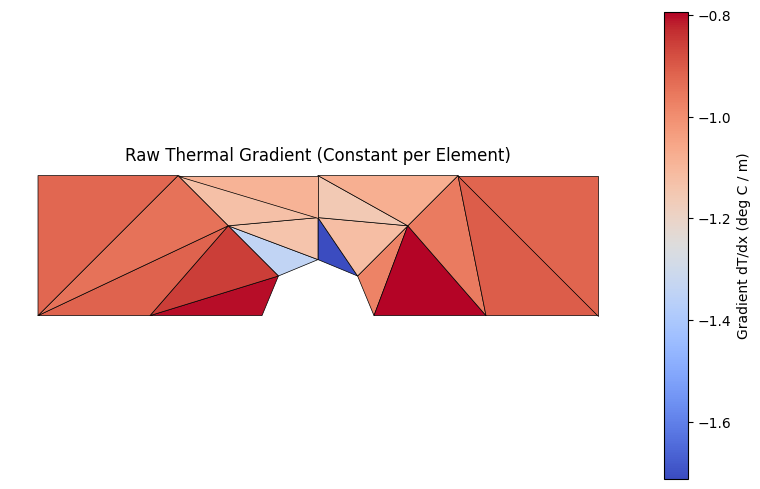

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

# --- 1. INPUT DATA ---
# Nodal coordinates (x, y)
x = np.array([60,57.0711,50,42.9289,40,80,66.0355,50.0,33.9645,20,100,75,50,25,0,100,0])
y = np.array([25,32.0711,35,32.0711,25,25,41.0355,42.5,41.0355,25,25,50,50,50,25,50,50])

# Element connectivity (node indices making up each triangle)
elements = np.array([
    [0,6,1],[0,5,6],[2,1,7],[1,6,7],[3,2,8],[2,7,8],[4,3,9],[3,8,9],
    [5,11,6],[5,10,11],[6,12,7],[6,11,12],[7,13,8],[7,12,13],[9,8,14],[8,13,14],
    [10,15,11],[14,13,16]
])

# Temperature solution at each node
solution = np.array([33.963309,38.347236,50.328796,61.497870,65.608024,18.073773,
                     31.528710,50.002465,68.324776,81.696074,0.000000,22.920809,
                     49.843212,76.971262,100.000000,0.000000,100.000000])

# Stack x and y into a single list of coordinates [[x1,y1], [x2,y2], ...]
nodes = np.column_stack((x, y))

# --- 2. SETUP ARRAYS ---
num_elems = len(elements)
dTdx_elem = np.zeros(num_elems) # Stores the constant gradient for each triangle

# --- 3. CALCULATE RAW GRADIENT (Per Element) ---
for i, elem in enumerate(elements):
    # Get Node IDs for this triangle
    n1, n2, n3 = elem

    # Get Coordinates (x, y) and Temperature (T) for the 3 nodes
    x1, y1 = nodes[n1]; T1 = solution[n1]
    x2, y2 = nodes[n2]; T2 = solution[n2]
    x3, y3 = nodes[n3]; T3 = solution[n3]

    # --- Calculate Area (A) ---
    # Formula: 2*Area = determinant of coordinates
    double_area = (x2 - x1)*(y3 - y1) - (x3 - x1)*(y2 - y1)

    # --- Calculate Geometric Coefficients (b) ---
    # b values represent the projection of the edge length onto the Y-axis.
    # These are required specifically for the X-direction gradient (dT/dx).
    b1 = y2 - y3
    b2 = y3 - y1
    b3 = y1 - y2

    # --- Calculate dT/dx ---
    # Finite Element shape function derivative formula:
    # dT/dx = (1 / 2A) * (b1*T1 + b2*T2 + b3*T3)
    val = (1.0 / double_area) * (b1*T1 + b2*T2 + b3*T3)

    # Store the raw, constant value for this specific element
    dTdx_elem[i] = val

# --- 4. PLOTTING THE RAW IMAGE ---
fig, ax = plt.subplots(figsize=(8, 5))

# Create the triangulation object for plotting
triang = mtri.Triangulation(x, y, elements)

# Use 'tripcolor' with 'facecolors'.
# This command tells matplotlib to color the faces of the triangles based
# on the element array provided, resulting in a discontinuous (blocky) look.
# We do NOT provide values at the nodes, only at the element centers.
raw_plot = ax.tripcolor(triang, facecolors=dTdx_elem, cmap='coolwarm', edgecolors='k', lw=0.5)

# Add Colorbar and Labels
cbar = fig.colorbar(raw_plot, ax=ax)
cbar.set_label('Gradient dT/dx (deg C / m)')

ax.set_title("Raw Thermal Gradient (Constant per Element)")
ax.set_aspect('equal') # Ensures geometry isn't stretched
plt.axis('off') # Hides the axis rulers for a cleaner "image only" look

plt.tight_layout()
plt.show()

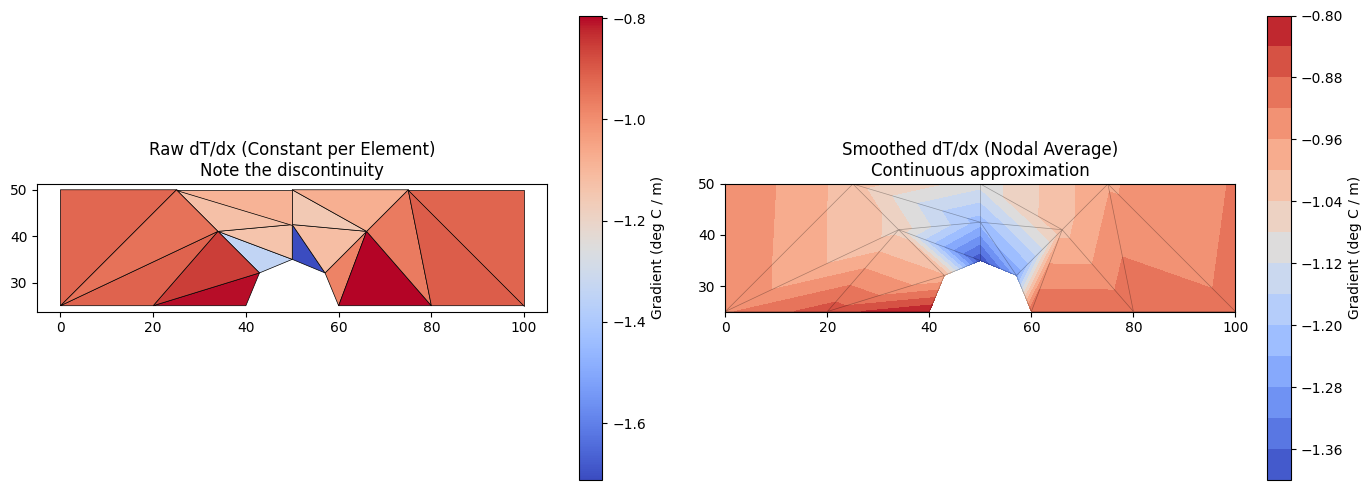

In [15]:
# x direction thermal gradient
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

# --- 1. INPUT DATA (From your previous message) ---
x = np.array([60,57.0711,50,42.9289,40,80,66.0355,50.0,33.9645,20,100,75,50,25,0,100,0])
y = np.array([25,32.0711,35,32.0711,25,25,41.0355,42.5,41.0355,25,25,50,50,50,25,50,50])
elements = np.array([
    [0,6,1],[0,5,6],[2,1,7],[1,6,7],[3,2,8],[2,7,8],[4,3,9],[3,8,9],
    [5,11,6],[5,10,11],[6,12,7],[6,11,12],[7,13,8],[7,12,13],[9,8,14],[8,13,14],
    [10,15,11],[14,13,16]
])
solution = np.array([33.963309,38.347236,50.328796,61.497870,65.608024,18.073773,31.528710,50.002465,68.324776,81.696074,0.000000,22.920809,49.843212,76.971262,100.000000,0.000000,100.000000])

# Stack x and y into a single list of coordinates [[x1,y1], [x2,y2], ...]
nodes = np.column_stack((x, y))

# --- 2. SETUP ARRAYS TO STORE RESULTS ---
num_elems = len(elements)
num_nodes = len(nodes)

# 'dTdx_elem' stores the constant gradient for each triangle (blocky)
dTdx_elem = np.zeros(num_elems)

# 'node_sum' and 'node_count' are used to average element values at nodes (smooth)
node_sum = np.zeros(num_nodes)
node_count = np.zeros(num_nodes)

# --- 3. LOOP THROUGH ELEMENTS TO CALCULATE GRADIENT ---
for i, elem in enumerate(elements):
    # Get Node IDs for this triangle
    n1, n2, n3 = elem

    # Get Coordinates (x, y) and Temperature (T) for the 3 nodes
    x1, y1 = nodes[n1]; T1 = solution[n1]
    x2, y2 = nodes[n2]; T2 = solution[n2]
    x3, y3 = nodes[n3]; T3 = solution[n3]

    # --- CALCULATE AREA (A) ---
    # Formula: 2*Area = determinant of coordinates
    double_area = (x2 - x1)*(y3 - y1) - (x3 - x1)*(y2 - y1)

    # --- CALCULATE GEOMETRIC COEFFICIENTS (b) ---
    # For dT/dx (X-Gradient), we need the 'b' terms.
    # b values are differences in Y coordinates.
    # This represents how much the "height" changes as you move along the edge.
    b1 = y2 - y3
    b2 = y3 - y1
    b3 = y1 - y2

    # --- CALCULATE dT/dx ---
    # The Finite Element formula for linear triangles:
    # dT/dx = (1 / 2A) * (b1*T1 + b2*T2 + b3*T3)
    val = (1.0 / double_area) * (b1*T1 + b2*T2 + b3*T3)

    # Store the raw element value
    dTdx_elem[i] = val

    # Add to the nodes of this element (for smoothing later)
    node_sum[n1] += val
    node_sum[n2] += val
    node_sum[n3] += val
    node_count[n1] += 1
    node_count[n2] += 1
    node_count[n3] += 1

# --- 4. CALCULATE SMOOTHED NODAL VALUES ---
# Avoid division by zero (just in case a node isn't connected)
node_count[node_count == 0] = 1.0
dTdx_nodal = node_sum / node_count

# --- 5. PLOTTING ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
triang = mtri.Triangulation(x, y, elements)

# PLOT 1: Element-wise (The "Truth" for T3 Elements)
# We use 'tripcolor' because we have 1 color per element
# 'facecolors' argument takes the element array
raw_plot = axes[0].tripcolor(triang, facecolors=dTdx_elem, cmap='coolwarm', edgecolors='k', lw=0.5)
fig.colorbar(raw_plot, ax=axes[0], label='Gradient (deg C / m)')
axes[0].set_title("Raw dT/dx (Constant per Element)\nNote the discontinuity")
axes[0].set_aspect('equal')

# PLOT 2: Smoothed (Averaged at Nodes)
# We use 'tricontourf' because we have values at nodes
smooth_plot = axes[1].tricontourf(triang, dTdx_nodal, levels=14, cmap='coolwarm')
fig.colorbar(smooth_plot, ax=axes[1], label='Gradient (deg C / m)')
axes[1].set_title("Smoothed dT/dx (Nodal Average)\nContinuous approximation")
axes[1].set_aspect('equal')

# Add mesh lines to seeing the grid
axes[1].triplot(triang, 'k-', lw=0.5, alpha=0.3)

plt.tight_layout()
plt.show()